In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
df=pd.read_csv('/kaggle/input/clothessizeprediction/final_test.csv')

In [ ]:
df.head

# 1. Features Engineering

In [ ]:
df['size'].unique()

In [ ]:
df=df.replace({'XXS':1, 'S':2,'M':3,'L':4,'XL':5,'XXL':6,'XXXL':7})

In [ ]:
df.isnull().sum()

In [ ]:
df=df.dropna(how='any')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.pairplot(df)

In [ ]:
df.describe()

# 1) I tried to drop outliers.

In [ ]:
q1=df['age'].quantile(0.99)
q2=df['age'].quantile(0.01)
df=df[df['age']<q1]
df=df[df['age']>q2]

In [ ]:
q3=df['weight'].quantile(0.99)
q4=df['weight'].quantile(0.01)
df=df[df['weight']<q3]
df=df[df['weight']>q4]

In [ ]:
sns.pairplot(df)

# 2) I added new feature 'BMI' BodyMassIndex in which we can find eacn physique.

In [ ]:
df['bmi']=df['weight']/(df['height']**2/100)

In [ ]:
sns.heatmap(df.corr(),annot=True)

# Which I should use ,'Classification' or 'Regression' ?

In [ ]:
from sklearn.model_selection import train_test_split
X=df.drop('size', axis=1)
y=df['size']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X_train,y_train)
clf.predict(X_test)
LinearRegressionScore = clf.score(X_test,y_test)
print("Accuracy of LR:",LinearRegressionScore*100)

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train,y_train)
model.predict(X_test)
np.array(y_test)
RandomForestClassifierScore = model.score(X_test,y_test)
print("Accuracy of RFC:",RandomForestClassifierScore*100)

# 'Regression' seems to be better.

# I tried to find better regression model by PyCaret.

In [ ]:
!pip install pycaret

In [ ]:
from pycaret.regression import *

In [ ]:
ex1=setup(df,target='size',silent=True)

In [ ]:
compare_models()

# catboost or xgboost seem to be better model. I chose xgboost.

In [ ]:
xg = create_model('xgboost')

In [ ]:
xg.fit(X_train,y_train)

In [ ]:
y_pred = xg.predict(X_test)

In [ ]:
y_test=pd.DataFrame(y_test)
y_pred=pd.DataFrame(y_pred)

In [ ]:
y_test = y_test.reset_index()

In [ ]:
y_test=y_test.drop('index', axis=1)

In [ ]:
df_pred=pd.concat([y_test,y_pred],axis=1)

In [ ]:
df_pred=df_pred.rename(columns={'size': 'actual', 0: 'pred'})

In [ ]:
df_pred.describe()

In [ ]:
df_pred.groupby('actual')['pred'].describe()

# Bacically, 25% to 75% of each model output will be high possibility to fit the size. For example,if I get 2.0 as output of prediction model, I should try XXS and S. But it depends on individuals. Considering the max prediction of each size, if you like larger one, you should choose lager size than indication.

# This is the rough indication table of 'size' and 'model output'.

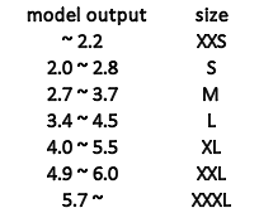